In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


In [7]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))


Epoch 1/100


KeyboardInterrupt: 

Mean Squared Error: 4084.3665521731436
Root Mean Squared Error: 63.909049063283234

['salary_in_usd'] / ['salary'] 


In [ ]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


['salary_in_usd'] / ['salary'] 
RMSE: 60.78381977426994

experience_mapping for ['experience_level']

In [ ]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

experience_mapping = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior': 3,
    'Executive': 4
}

# Map experience levels to ordinal numbers
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


experience_mapping for ['experience_level']
RMSE: 57.54844132269867

Final Code

In [13]:
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Feature 1:
# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

# Feature 2:
experience_mapping = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior': 3,
    'Executive': 4
}

# Map experience levels to ordinal numbers
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)


# Feature 3:
# Calculate the percentile rank of each salary within its job category
df['Percentile'] = df.groupby('job_category')['salary'].rank(pct=True)

# Normalize the percentile ranks to a scale of 0 to 1
min_percentile = df['Percentile'].min()
max_percentile = df['Percentile'].max()
df['Normalized_Salary_within_Job_Category'] = (df['Percentile'] - min_percentile) / (max_percentile - min_percentile)

# Drop the temporary 'Percentile' column if you don't need it anymore
df.drop(columns=['Percentile'], inplace=True)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.0)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])


# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


Epoch 1/100
106/106 [==============================] - 8s 22ms/step - loss: 16282.7178 - mse: 16282.7178 - val_loss: 9954.0742 - val_mse: 9954.0742
Epoch 2/100
106/106 [==============================] - 1s 11ms/step - loss: 7013.9756 - mse: 7013.9756 - val_loss: 5226.7456 - val_mse: 5226.7456
Epoch 3/100
106/106 [==============================] - 1s 13ms/step - loss: 4466.2373 - mse: 4466.2373 - val_loss: 4188.8232 - val_mse: 4188.8232
Epoch 4/100
106/106 [==============================] - 1s 13ms/step - loss: 4001.5374 - mse: 4001.5374 - val_loss: 4049.8679 - val_mse: 4049.8679
Epoch 5/100
106/106 [==============================] - 1s 12ms/step - loss: 3947.9058 - mse: 3947.9058 - val_loss: 4057.3345 - val_mse: 4057.3345
Epoch 6/100
106/106 [==============================] - 1s 14ms/step - loss: 3944.9294 - mse: 3944.9294 - val_loss: 3966.5356 - val_mse: 3966.5356
Epoch 7/100
106/106 [==============================] - 2s 15ms/step - loss: 3847.3838 - mse: 3847.3838 - val_loss: 3765.14

Normalized Salary within Job Category
RMSE: 24.779573173916585

59/59 [==============================] - 0s 5ms/step


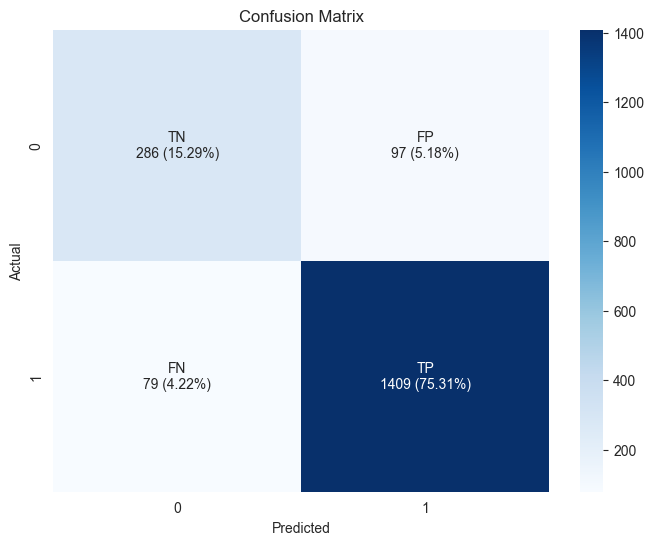

Accuracy: 0.9059326563335115
Precision: 0.9355909694555112
Recall: 0.9469086021505376
RMSE: 26.517824651983673


In [10]:
# Make predictions on the scaled test set
predictions_scaled = model.predict(X_test_reshaped)

# Convert predictions back to original scale
predictions = predictions_scaled.flatten()

# Define thresholds for classification
threshold_positive = 100  # Define a suitable threshold based on your problem

# Classify predictions into two categories based on the threshold
y_test_class = (y_test >= threshold_positive)
predictions_class = (predictions >= threshold_positive)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_class, predictions_class)

# Calculate percentages
total = np.sum(conf_matrix)
percentages = (conf_matrix / total) * 100

# Define labels for each cell with amount, percentage, and the type of classification
labels = np.empty_like(conf_matrix, dtype=object)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == 0 and j == 0:  # True Negative
            labels[i, j] = f"TN\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        elif i == 0 and j == 1:  # False Positive
            labels[i, j] = f"FP\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        elif i == 1 and j == 0:  # False Negative
            labels[i, j] = f"FN\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        else:  # True Positive
            labels[i, j] = f"TP\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy, precision, and recall
accuracy = accuracy_score(y_test_class, predictions_class)
precision = precision_score(y_test_class, predictions_class)
recall = recall_score(y_test_class, predictions_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Calculate and print RMSE
mse = mean_squared_error(y_test, predictions)
print("RMSE:", np.sqrt(mse))

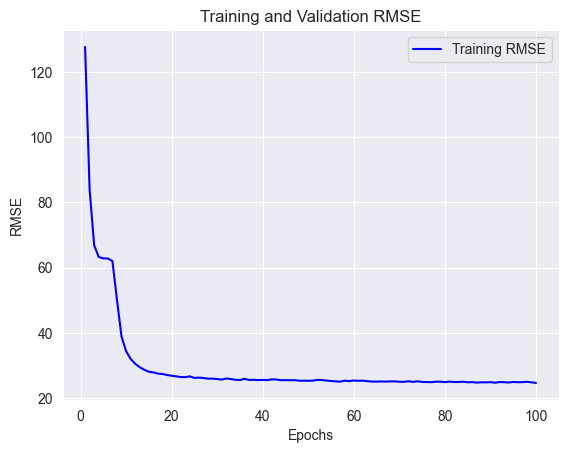

In [19]:
import matplotlib.pyplot as plt

# Extract RMSE values from the training history
train_rmse = np.sqrt(history.history['mse'])

# Plot RMSE vs. epochs
epochs = range(1, len(train_rmse) + 1)

plt.figure(facecolor='white')  # Set white background
plt.plot(epochs, train_rmse, 'b', label='Training RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [22]:
# Load the data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Feature Engineering
# Feature 1: Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

# Feature 2: Map experience levels to ordinal numbers
experience_mapping = {'Entry-level': 1, 'Mid-level': 2, 'Senior': 3, 'Executive': 4}
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)

# Feature 3: Calculate the percentile rank of each salary within its job category
df['Percentile'] = df.groupby('job_category')['salary'].rank(pct=True)
# Normalize the percentile ranks to a scale of 0 to 1
min_percentile = df['Percentile'].min()
max_percentile = df['Percentile'].max()
df['Normalized_Salary_within_Job_Category'] = (df['Percentile'] - min_percentile) / (max_percentile - min_percentile)
# Drop the temporary 'Percentile' column if you don't need it anymore
df.drop(columns=['Percentile'], inplace=True)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(columns=["salary_in_usd", "salary"])
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define parameter combinations
learning_rates = [0.01, 0.001, 0.0001]
dropouts = [0, 0.2, 0.5]
epochs_list = [50, 100, 200]

# Initialize results table
results = []

# Loop over parameter combinations
for lr in learning_rates:
    for dropout_rate in dropouts:
        for epochs in epochs_list:
            # Define LSTM model
            input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
            lstm_layer = LSTM(128, return_sequences=True)(input_layer)
            dropout_layer = Dropout(dropout_rate)(lstm_layer)
            lstm_layer2 = LSTM(64)(dropout_layer)
            output_layer = Dense(1, activation='linear')(lstm_layer2)
            model = Model(inputs=input_layer, outputs=output_layer)

            # Compile the model
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

            # Train the model
            history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=64, validation_split=0.1, verbose=0)

            # Evaluate the model
            y_pred = model.predict(X_test_reshaped)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Record results
            results.append([lr, dropout_rate, epochs, rmse])

# Create DataFrame for results
results_df = pd.DataFrame(results, columns=['Learning Rate', 'Dropout', 'Epochs', 'Final RMSE'])

# Display results table
print(results_df)


59/59 [==============================] - 2s 4ms/step
    Learning Rate  Dropout  Epochs  Final RMSE
0          0.0100      0.0      50   26.181275
1          0.0100      0.0     100   24.888934
2          0.0100      0.0     200   25.513078
3          0.0100      0.2      50   25.921124
4          0.0100      0.2     100   26.205016
5          0.0100      0.2     200   24.961716
6          0.0100      0.5      50   25.460125
7          0.0100      0.5     100   25.659675
8          0.0100      0.5     200   25.037021
9          0.0010      0.0      50   38.125905
10         0.0010      0.0     100   26.486403
11         0.0010      0.0     200   25.262171
12         0.0010      0.2      50   37.660914
13         0.0010      0.2     100   25.967569
14         0.0010      0.2     200   25.051040
15         0.0010      0.5      50   36.790459
16         0.0010      0.5     100   26.808867
17         0.0010      0.5     200   25.777992
18         0.0001      0.0      50  124.183403
19     

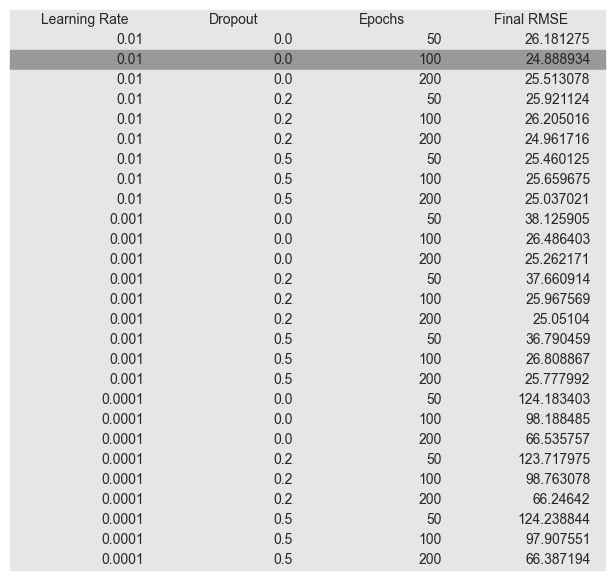

In [27]:
import matplotlib.pyplot as plt

# Data
data = [
    [0.0100, 0.0, 50, 26.181275],
    [0.0100, 0.0, 100, 24.888934],
    [0.0100, 0.0, 200, 25.513078],
    [0.0100, 0.2, 50, 25.921124],
    [0.0100, 0.2, 100, 26.205016],
    [0.0100, 0.2, 200, 24.961716],
    [0.0100, 0.5, 50, 25.460125],
    [0.0100, 0.5, 100, 25.659675],
    [0.0100, 0.5, 200, 25.037021],
    [0.0010, 0.0, 50, 38.125905],
    [0.0010, 0.0, 100, 26.486403],
    [0.0010, 0.0, 200, 25.262171],
    [0.0010, 0.2, 50, 37.660914],
    [0.0010, 0.2, 100, 25.967569],
    [0.0010, 0.2, 200, 25.051040],
    [0.0010, 0.5, 50, 36.790459],
    [0.0010, 0.5, 100, 26.808867],
    [0.0010, 0.5, 200, 25.777992],
    [0.0001, 0.0, 50, 124.183403],
    [0.0001, 0.0, 100, 98.188485],
    [0.0001, 0.0, 200, 66.535757],
    [0.0001, 0.2, 50, 123.717975],
    [0.0001, 0.2, 100, 98.763078],
    [0.0001, 0.2, 200, 66.246420],
    [0.0001, 0.5, 50, 124.238844],
    [0.0001, 0.5, 100, 97.907551],
    [0.0001, 0.5, 200, 66.387194]
]

# Create figure and axis
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Create table
table = ax.table(cellText=data, loc='center', colLabels=['Learning Rate', 'Dropout', 'Epochs', 'Final RMSE'])

# Modify table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Highlight second row
for key, cell in table.get_celld().items():
    cell.set_color((0.9, 0.9, 0.9))  # Set color for all cells
    if key[0] == 2:  # Row index for the second row
        cell.set_color((0.6, 0.6, 0.6))  # Set color for the second row

# Show table
plt.show()
